---
title: "The Gumbel distribution"
author: Stefan Heyder
date: '2024-08-09'
slug: gumbel_distribution
categories: []
tags: []
draft: false
---


I recently learned about the Gumbel softmax trick, which seemingly allows smooth sampling from a discrete distribution. In writing this post, I want to learn more about the Gumbel distribution that appears in this trick, details on the trick may follow in a separate post.

The main component in the softmax trick is the following distribution, due to Gumbel (aptly named after him).

::: {.callout-note icon=false}
## Definition (Gumbel distribution)

For $\mu \in \mathbf R$ and $\beta \in \mathbf R_{> 0}$ the $\operatorname{Gumbel}(\mu, \beta)$ distribution has the CDF 
$$
\begin{align*}
    F: (-\infty, \infty) \to (0, 1) && x \mapsto \exp \left( -\exp \left( - \frac{x - \mu}{\beta} \right)  \right).
\end{align*}
$$
:::

Let us quickly ensure that this defines a distribution: this CDF is strictly monotonically increasing and for $x \to -\infty$ it goes to $0$, while for $x \to \infty$ it goes to $\exp(0) = 1$. By differentiating the CDF we obtain the density (with respect to Lebesgue measure), which is 
$$
\frac{1}{\beta} \exp \left( - \frac{x - \mu}{\beta} -\exp \left( - \frac{x - \mu}{\beta} \right) \right),
$$
so the distribution is a continuous one.

Simulating from this distribution is straight-forward using the inverse CDF trick: simulate $U \sim \operatorname{Unif}(0,1)$ and let $$G = F^{-1}(U) = -\beta\log( -\log (U))  + \mu,$$ then $G \sim \operatorname{Gumbel}(\mu, \beta)$. Let's draw some samples from the standard Gumbel distribution, i.e. where $\mu = 0$ and $\beta = 1$.


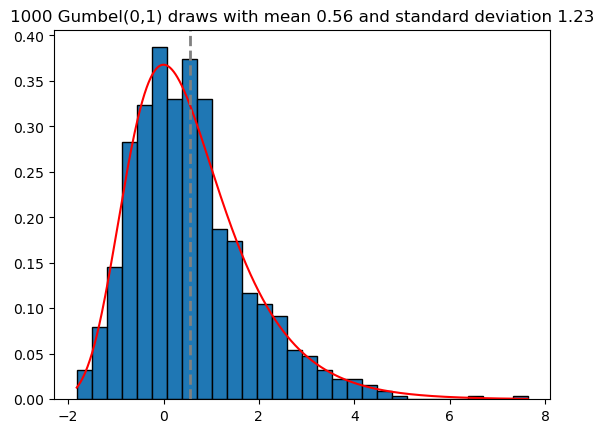

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sim_gumbel(n, mu, beta):
    return - beta * np.log(-np.log(np.random.uniform(size=n))) + mu

def density_gumbel(x,mu,beta):
    return (1/beta) * np.exp(-(x-mu)/beta-np.exp(-(x-mu)/beta))

sims = sim_gumbel(1000, 0, 1)
xmin, xmax = min(sims), max(sims)
plt.hist(sims, bins=30, edgecolor='black', density=True)
plt.plot(np.linspace(xmin, xmax, 1000), density_gumbel(np.linspace(xmin, xmax, 1000), 0, 1), 'r')
plt.title(f"{len(sims)} Gumbel(0,1) draws with mean {np.mean(sims):.2f} and standard deviation {np.std(sims):.2f}")
plt.axvline(np.mean(sims), color='grey', lw=2, linestyle="--")
plt.show()

From these simulations and the right skew visible in the density, we can guess that the mean of the standard Gumbel is not $0$. Indeed, if $G \sim \operatorname{Gumbel}(0,1)$, then [see [wikipedia](https://en.wikipedia.org/wiki/Euler%27s_constant#Integrals), I have not been able to find a concrete proof of this yet]{.aside}
$$
    \mathbf E G = \int_{0}^1 F^{-1}(u) \mathrm d u = \int_{0}^1 -\log( - \log u) \mathrm d u = \gamma \approx 0.5772,
$$
where $\gamma$ is the Euler-Mascheroni constant. 

From the definition, we can see that the Gumbel distributions form a location-scale family, i.e. if $G \sim  \operatorname{Gumbel}(\mu, \beta)$, then $aG + b \sim \operatorname{Gumbel}(a\mu + b, a^2\beta)$. Similar to the normal distribution, this allows us to focus on the standard Gumbel distribution $\operatorname{Gumbel}(0,1)$.

The origins of the Gumbel distribution go back to the early 1930s, when Gumbel discovered the distribution as a limiting distribution of the maximum i.i.d. exponentially distributed samples. This makes the Gumbel distribution one of the three GEV (generalized extreme value) distributions, the others being the Fréchet and the reverse Weibull distribution. Actually, if $X \sim \operatorname{Gumbel}(0,1)$, then $\exp (X)$ and $- \exp(-X)$ follow a Fréchet and a reverse Weibull distribution respectively. 

:::{.callout-note .icon-false}
## Theorem (limit theorem for the Gumbel distribution)

For $i \in \mathbf N$ let $X_i \stackrel{\text{i.i.d.}}{\sim} \operatorname{Exp}(1)$ and let $Y_n = \max \{X_1, \dots, X_n\}$ be the maximum value in the first $n$ samples. Then, as $n \to \infty$, 
$$
    Y_{n} - \log n \stackrel{\mathcal D}{\longrightarrow} \operatorname{Gumbel}(0, 1).
$$
:::

:::{.callout-tip collapse="true" icon=false}
## Proof
The CDF of $Y_n - \log n$ is, for $y \geq - \log n$, 
$$
\begin{align*}
    \mathbf P \left( Y_{n} - \log n \leq y \right) &=  \mathbf P \left( Y_{n} \leq y + \log n \right) = (1 - \exp(-(y + \log n)))^{n} \\
    &= \left(1 - \frac{\exp(-y)}{n}\right)^{n}\to \exp(-\exp(-y)) = F(y).
\end{align*}
$$

:::

Again, let's verify by simulation that this is true, comparing to the density of the standard Gumbel distribution.

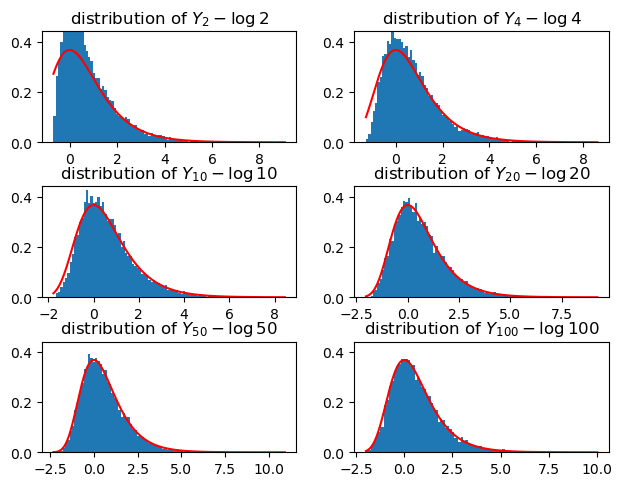

In [2]:
def sim_exponential(n, lambd):
    return -1/lambd * np.log(np.random.uniform(size=n))


fig, axs = plt.subplots(3,2)
fig.tight_layout()
ns = [2, 4, 10, 20, 50, 100]
m = 10000

for ax, n in zip(axs.flatten(), ns):
    X = sim_exponential((m, n), 1)
    Y = np.max(X, axis = 1)
    Z = Y - np.log(n)
    min_z, max_z = min(Z), max(Z)
    ax.hist(Z, bins=100, density=True)
    ax.plot(np.linspace(min_z, max_z, 1000), density_gumbel(np.linspace(min_z, max_z, 1000), 0, 1), 'r')
    ax.set_title(f"distribution of $Y_{{ {n} }} - \\log {n}$")
    # mode of gumbel distribution is at mu
    ax.set_ylim(0, 1.2* density_gumbel(0,0,1))

plt.show()

As you can see, already for $n=10$ there is good fit between the distribution of $Y_n - \log n$ and $\operatorname{Gumbel}(0, 1)$.

In the limit theorem, we had to subtract $\log n$ from the maximum. Intuitively, this is necessary to ensure that the maximum does not diverge to $\infty$, so we obtain an actual distribution in the limit. This is similar to subtracting the mean in the central limit theorem (CLT).

Similar to the CLT, the limit theorem holds for a much larger class of distributions, not just exponential distributions and similar to the CLT we have to stabilize the maxima to obtain a valid limit. The next theorem makes this precise.

::: {.callout-note}

## Theorem (limit theorem for extrema) [@Johnson1995Continuous]

Let $X_i, i \in \mathbf N$ be a sequence of i.i.d. random variables, let $Y_n = \max_{i = 1, \dots, n} X_i$ be the running maximum and consider 
$$
    Z_{n} = Y_{n} - b_{n},
$$
for a sequence of real numbers $b_n$, such that for every $k$ $b_{kn} - b_n$ converges as $n\to \infty$ for every $k$.[I could not get rid of this technical assumption, see the sidenotes in the proof.]{.aside}

If $Z_n$ converges in distribution to a distribution with an injective CDF[again, could not get rid of this either]{.aside}, then the limiting distribution is a Gumbel distribution. 

:::

:::{.callout-tip collapse="true" icon=false}
## Proof

I basically follow [@Johnson1995Continuous] in this proof.
Let $G$ be the CDF of the limiting distribution and $Z \sim G$ and denote general CDFs by $F$. We have to show that 
$$
    G(x) = \exp \left( - \exp \left( -\frac{x - \mu}{\beta} \right) \right)
$$
for some $\mu \in \mathbf R$ and $\beta \in \mathbf R_{> 0}$. 
Let $k\in\mathbf N$ and partition the random variables into blocks of size $n$, and consider the block-wise maximum, i.e.  
$$
    \begin{align*}
        Y^{j}_{n} = \max_{i = 1, \dots, n} X_{(j - 1)k + i} && j = 1, \dots, k.
    \end{align*}
$$
Let $Z^j_n = Y^j_n - b_n$ and let $n \to \infty$. Then  $Z^j_n \stackrel{\mathcal D}{\longrightarrow} Z$ for $j = 1, \dots, k$. 

Now $Z_{kn} = \max_{j = 1, \dots, k} Z^j_n + b_{n} - b_{kn}$ also converges to $Z$ in distribution.
By the properties of the CDF and the i.i.d. assumption, we have  
$$
    F_{Z_{kn}} (z) = \mathbf P \left( \max_{j = 1, \dots k} Z^{j}_n \leq z - b_{n} + b_{kn} \right)  = (F_{Z^{1}_n}(z - b_{n} + b_{kn}))^{k}.
$$
As $n$ goes to $\infty$, the left hand side converges to $G(z)$, and so the right-hand side does as well. Assuming $-b_n + b_{kn} \to c_{k}$ as $n\to \infty$, the right-hand side converges to $G(z - c_k)^k$ as well. [[@Johson1995Continuous] as well as [wikipedia](https://en.wikipedia.org/wiki/Fisher%E2%80%93Tippett%E2%80%93Gnedenko_theorem#References) directly use $-b_n + b_{kn} = b_k$, but I haven't seen a direct proof yet. [@Haan2006Extreme] goes a different, more precise route.]{.aside} Thus 
$$
    G(z) = G(z - c_{k})^{k},
$$
or, equivalently, 
$$
    G(z + c_{k}) = G(z)^{k}.
$$
This implies 
$$
    G(z + c_{k} + c_{l}) = (G(z)^{k})^{l} = G(z)^{kl} = G(z + c_{kl}),
$$
so $c_k + c_l = c_{kl}$, if $G$ is injective [again, [@Johnson1995Continuous] skip over this]. 
Thus $c_k = \xi\log k$ for some $\xi \in \mathbf R$.

Taking logs twice, we obtain
$$
    \log k + \log (- \log G(z)) = \log - \log G(z + \xi \log k),
$$
and so $z \mapsto \log (- \log G(z))$ is an affine function, which was just what we had to show.

:::

Finally, to check whether this works, let us perform some simulations for the maximum of $n$ standard normal draws.

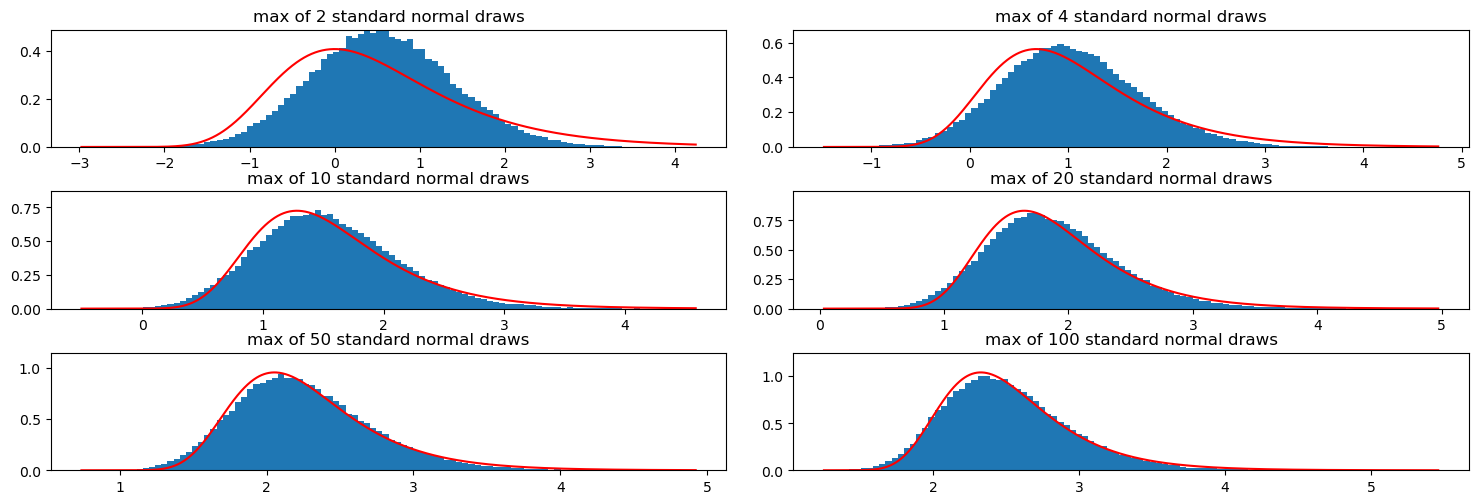

In [28]:
from scipy.stats.distributions import norm

fig, axs = plt.subplots(3,2, figsize=(15,5))
fig.tight_layout()
ns = [2, 4, 10, 20, 50, 100]
m = 100000

for ax, n in zip(axs.flatten(), ns):
    X = np.random.normal(0, 1, (m, n))
    Y = np.max(X, axis = 1)
    min_z, max_z = min(Y), max(Y)
    ax.hist(Y, bins=100, density=True)
    mu = norm.ppf(1-1/n)
    beta = norm.ppf(1 - 1 / n / np.exp(1)) - mu
    ax.plot(np.linspace(min_z, max_z, 1000), density_gumbel(np.linspace(min_z, max_z, 1000), mu, beta), 'r')
    ax.set_title(f"max of {n} standard normal draws")
    # mode of gumbel distribution is at mu
    ax.set_ylim(0, 1.2* density_gumbel(mu,mu,beta))

plt.show()